In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [30]:
def promedio(lst):
    return (sum(lst)/len(lst))

def desvioEstandar(lst):
    prom = promedio(lst)
    return (sum([(x-prom)**2 for x in lst])/len(lst))**0.5

def buscarIdxAntNull(lst):
    i = 0
    while i < len(lst) and lst[i] != 'null\n':
        i+=1
    return (i-1)

def buscarIdxPostNull(lst):
    i = buscarIdxAntNull(lst)+1
    while i < len(lst) and lst[i] == 'null\n':
        i+=1
    #no se porque corta un indice antes, me canse y le sumo uno a la salida, en otro momento lo veo
    return (i+1)

def separarLstRtt(lstRtt):
    idxAnt = buscarIdxAntNull(lstRtt)
    idxPost = buscarIdxPostNull(lstRtt)
    prom = (float(lstRtt[idxAnt]) + float(lstRtt[idxPost]))/2
    lst1 = [(float(lstRtt[idx]), idx+1) for idx in range(idxAnt+1)]
    lstnull = [(prom, idx+1) for idx in range(idxAnt+1, idxPost)]
    lst2 = [(float(lstRtt[idx]), idx+1) for idx in range(idxPost,len(lstRtt))]
    return lst1, lstnull, lst2

# www.u-tokyo.ac.jp

In [31]:
dfAllHops = pd.read_csv("experimentos/www.u-tokyo.ac.jp-allHops.csv", sep=",")

with open('experimentos/www.u-tokyo.ac.jp-ips.csv') as csv:
    lstIps = csv.readlines()
lstIps = [s[:len(s)-1] for s in lstIps]

with open('experimentos/www.u-tokyo.ac.jp-rtt.csv') as csv:
    lstRtt = csv.readlines()
#los valores de los rtt que son null les doy el promedio del anterior no null y el siguiente no null
#(rtt, idx)
lstRtt1, lstRttNull, lstRtt2 = separarLstRtt(lstRtt)

with open('experimentos/www.u-tokyo.ac.jp-salto.csv') as csv:
    lstSaltos = csv.readlines()
lstSaltos = [s[:len(s)-1] for s in lstSaltos]

## RTT entre saltos (restar los valores promediados a cada salto)

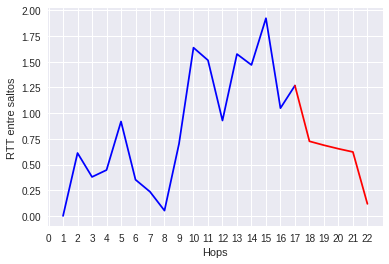

In [34]:
lstUnionRtt = [x for x,y in lstRtt1] + [x for x,y in lstRttNull] + [x for x,y in lstRtt2]
lstProm = [promedio(lstUnionRtt[:idx+1]) for idx in range(len(lstUnionRtt))]
lstRttEntreSaltos = [lstUnionRtt[i]-lstProm[i] for i in range(len(lstUnionRtt))]

lstX1 = [y for x,y in lstRtt1]
lstXNull = [y for x,y in lstRttNull]
lstX2 = [y for x,y in lstRtt2]

lstRttEntreSaltos1 = [lstRttEntreSaltos[idx-1] for idx in lstX1]
lstRttEntreSaltosNull = [lstRttEntreSaltos[idx-1] for idx in lstXNull]
lstRttEntreSaltos2 = [lstRttEntreSaltos[idx-1] for idx in lstX2]

lstRttEntreSaltosNull = [lstRttEntreSaltos1[len(lstRttEntreSaltos1)-1]] + lstRttEntreSaltosNull + [lstRttEntreSaltos2[0]]
lstXNull = [lstX1[len(lstX1)-1]] + lstXNull + [lstX2[0]]

plt.plot(lstX1, lstRttEntreSaltos1, 'blue')
plt.plot(lstXNull, lstRttEntreSaltosNull, 'red')
plt.plot(lstX2, lstRttEntreSaltos2, 'blue')
plt.ylabel('RTT entre saltos')
plt.xlabel('Hops')
plt.xticks(range(len(lstUnionRtt)+1), range(len(lstUnionRtt)+1))
plt.show()

## RTT entre saltos en la ruta, graficar el valor (X i − X̄)/S

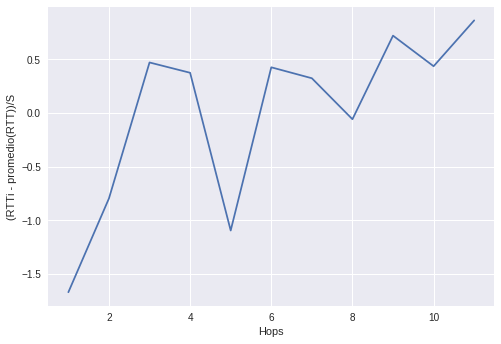

In [8]:
prom = promedio(lstRtt)
s = desvioEstandar(lstRtt)
lstVal = [(x-prom) for x in lstRtt]
lstX = range(1,len(lstRtt)+1)

plt.plot(lstX, lstVal)
plt.ylabel('(RTTi - promedio(RTT))/S')
plt.xlabel('Hops')
plt.show()

## Porcentaje que no responden los Time exceeded

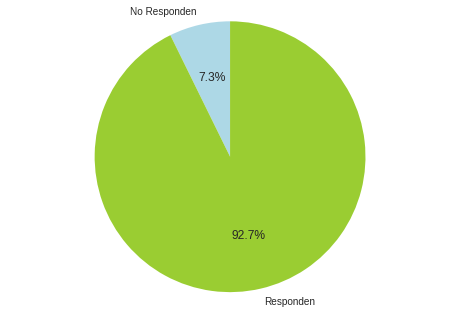

In [15]:
lstAllHops = dfAllHops['salto_intercontinental']
cantNull = 0
for ip in lstAllHops:
    if ip == 'null':
        cantNull+=1

porcentajes = [cantNull, len(lstAllHops) - cantNull]

labels = 'No Responden', 'Responden'
explode = [0,0]

fig1, ax1 = plt.subplots()
ax1.pie(porcentajes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=False, startangle=90, colors=['lightblue', 'yellowgreen'])
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

## Saltos Internacionales